In [ ]:
import os

In [ ]:
%%capture
# https://drive.google.com/file/d/11zzAlVTNLvcgZQaaTGLIj8hpqHdJWNM6/view?usp=sharing
!wget -O Epileptic_Seizure_Recognition.csv --no-check-certificate "https://docs.google.com/uc?export=download&id=11zzAlVTNLvcgZQaaTGLIj8hpqHdJWNM6"

In [ ]:
PATH_ = "/content/Epileptic_Seizure_Recognition.csv"
if os.path.exists(PATH_):
  print("Data loaded succesfully")

Data loaded succesfully


In [ ]:
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model
from keras.utils import np_utils
from keras.layers import Input, Dense, Activation, Dropout

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


In [ ]:
data = pd.read_csv(PATH_)

In [ ]:
data.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,...,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,...,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,...,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,...,38,26,10,-4,-13,-8,0,10,19,29,57,63,45,7,-13,-23,-9,9,11,3,-1,-2,4,18,27,27,14,15,11,10,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [ ]:
# Converting the dataset for binary classification

data['y'] = data['y'].replace([2,3,4,5], 0)

In [ ]:
from sklearn import preprocessing

X=data.values
X=X[:,1:-1]

# Applying min max scaler
scaler = preprocessing.MinMaxScaler()
data_rescaled = scaler.fit_transform(X)

y=np.array(data['y'])
Y=np_utils.to_categorical(y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=123) # Train-Test Split
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.50, random_state=123) # Test-Validation Split

# **Applying PCA for feature extraction**

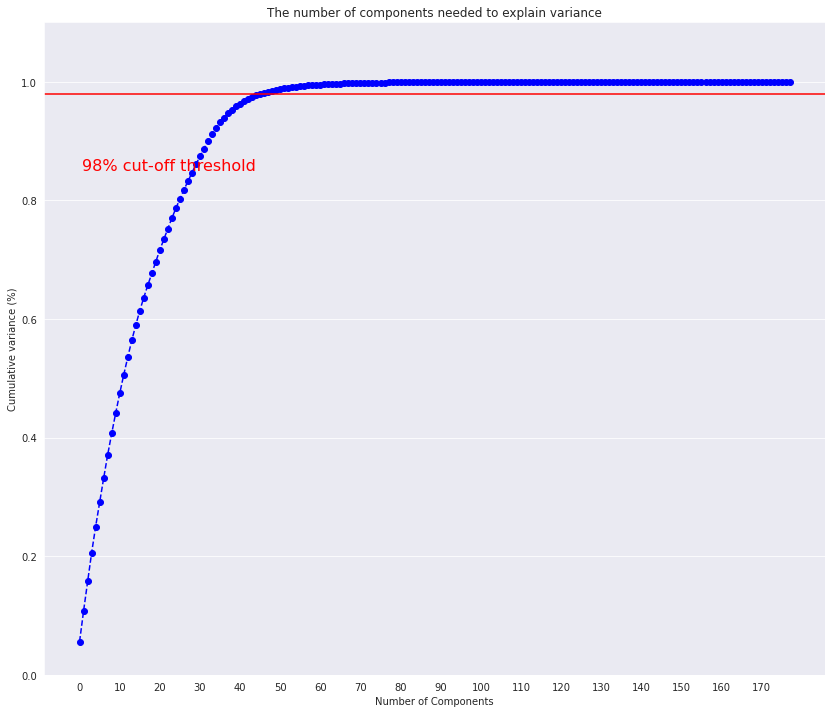

In [ ]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train)

plt.rcParams["figure.figsize"] = (14,12)

fig, ax = plt.subplots()
xi = np.arange(0, 178, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 178, step=10)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.98, color='r', linestyle='-')
plt.text(0.5, 0.85, '98% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [ ]:
n_components = 0.98
pca=PCA(n_components=n_components, whiten=True)
pca.fit(X_train)

Train_PCA = pca.transform(X_train)
Val_PCA = pca.transform(X_val)
Test_PCA = pca.transform(X_test)

In [ ]:

print("Shape of training data, X and Y: " + str(Train_PCA.shape) + ", "+  str(Y_train.shape),"\n")
print("Shape of validation data, X and Y: " + str(Val_PCA.shape) + ", "+  str(Y_val.shape),"\n")
print("Shape of test data, X and Y: " + str(Test_PCA.shape) + ", "+  str( Y_test.shape),"\n")

Shape of training data, X and Y: (9200, 47), (9200, 2) 

Shape of validation data, X and Y: (1150, 47), (1150, 2) 

Shape of test data, X and Y: (1150, 47), (1150, 2) 



In [ ]:
# Structure of the model

def Seizure_Model(input_shape, classes):
  
  X_input = Input(input_shape)
  
  '''
  X = Dense(512, activation='relu')(X_input)
  
  X = Dense(256, activation='relu')(X)
  X = Dropout(0.8)(X)
  
  X = Dense(128, activation='relu')(X)
  X = Dense(128, activation='relu')(X)
  X = Dropout(0.8)(X)

  X = Dense(128, activation='relu')(X_input)
  X = Dense(128, activation='relu')(X)
  X = Dropout(0.7)(X)
  '''
  
  X = Dense(64, activation='relu')(X_input)  
  X = Dense(64, activation='relu')(X)
  X = Dropout(0.7)(X)

  X = Dense(32, activation='relu')(X)
  X = Dense(32, activation='relu')(X)
  X = Dropout(0.7)(X)
  
  X = Dense(16, activation='relu')(X)
  X = Dense(16, activation='relu')(X)
  X = Dropout(0.7)(X)
  
  X = Dense(8, activation='relu')(X)
  
  X = Dense(classes, activation='sigmoid')(X)

  model = Model(inputs = X_input, outputs = X, name='Seizure_Model')
  
  return model

In [ ]:
# Initializing and compiling the model
model = Seizure_Model(input_shape = (Train_PCA.shape[1],), classes = 2)
model.summary()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

Model: "Seizure_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 47)]              0         
_________________________________________________________________
dense_90 (Dense)             (None, 64)                3072      
_________________________________________________________________
dense_91 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_93 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)              

In [ ]:
# Fitting the model using batch size 10 and 50 epochs

history = model.fit(Train_PCA, Y_train, 10, 20, validation_data=(Val_PCA, Y_val))

Epoch 1/20
920/920 [==============================] - 2s 2ms/step - loss: 0.5452 - accuracy: 0.8113 - val_loss: 0.1873 - val_accuracy: 0.9348
Epoch 2/20
920/920 [==============================] - 2s 2ms/step - loss: 0.2288 - accuracy: 0.9241 - val_loss: 0.1199 - val_accuracy: 0.9470
Epoch 3/20
920/920 [==============================] - 2s 2ms/step - loss: 0.1867 - accuracy: 0.9412 - val_loss: 0.1223 - val_accuracy: 0.9522
Epoch 4/20
920/920 [==============================] - 2s 2ms/step - loss: 0.1488 - accuracy: 0.9510 - val_loss: 0.1125 - val_accuracy: 0.9548
Epoch 5/20
920/920 [==============================] - 2s 2ms/step - loss: 0.1284 - accuracy: 0.9579 - val_loss: 0.1136 - val_accuracy: 0.9565
Epoch 6/20
920/920 [==============================] - 2s 2ms/step - loss: 0.1072 - accuracy: 0.9680 - val_loss: 0.0947 - val_accuracy: 0.9652
Epoch 7/20
920/920 [==============================] - 2s 2ms/step - loss: 0.0994 - accuracy: 0.9659 - val_loss: 0.1009 - val_accuracy: 0.9713
Epoch 

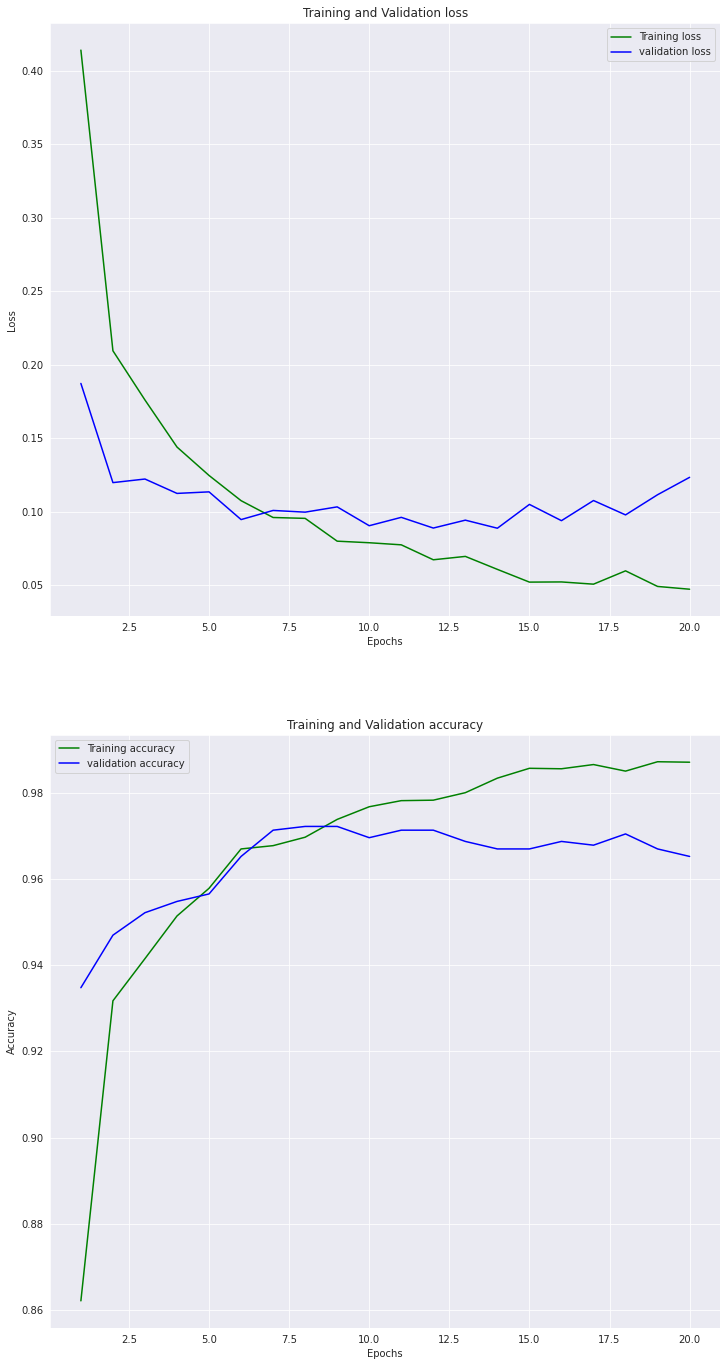

In [ ]:
# Comparing loss and accuracy of training and validation data.

loss_train = history.history['loss']
loss_val = history.history['val_loss']

acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']

epochs = range(1,21)

plt.figure(1, figsize = (12,24))

plt.subplot(211)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(212)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Making preditions on test data

y_pred = model.predict(Test_PCA)
y_pred.shape 

(1150, 2)

The confusion matrix is as follows: 
[[914  14]
 [ 18 204]] 



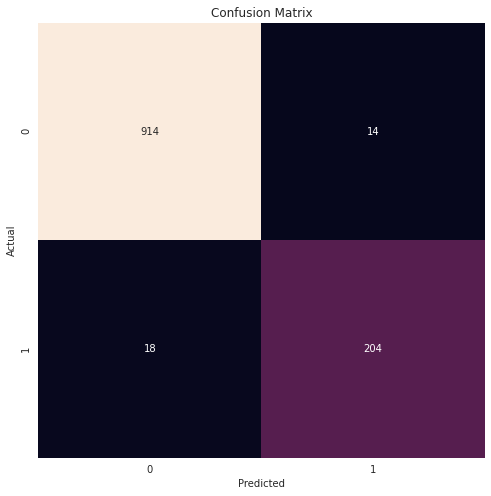



The accuracy of the predictor is: 97.21739130434783%


In [ ]:
from sklearn import metrics

matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1)) # Confusion Matrix

accuracy = metrics.accuracy_score(Y_test.argmax(axis=1), y_pred.argmax(axis=1)) # Accuracy

print("The confusion matrix is as follows: ")
print(matrix,"\n")

plt.figure(figsize=(8, 8))
sns.heatmap(matrix, annot=True, vmin=0, fmt='g', cbar=False)
# plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
# plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print("\n")
print("The accuracy of the predictor is: " + str(accuracy*100) + "%")